# Evaluation of UNET performance upon common distortions

The aim of this notebook is to provide some informations about how a UNET initially trained to segment cells is perturbated by some common distortions applied on the input images. The tested distortions applied on the inputs are an added 2D gaussian, a gaussian noise as well as a rescaling of the input images. To evaluate the performance of the UNET, several plots are generated: the accuracy, the Jaccard index and the number of detected cells in function of the degree of degradation that depends on the parameters of the distortions.

### $\bullet$ Importing libraries and utilitary functions

In [1]:
# Import python libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow

# Import distortion filters and utilitary functions.
from distortions import add_gaussian, zoom_image, zoom_image_to_meet_shape, add_gaussian_noise
from utils import *
from image_processing_methods import DogImageProcessingMethod, DenoiserImageProcessingMethod
from plots import show_image_mask, show_image_pred, plot_results

In [2]:
# Set seeds of random number generators to guarantee reproducibility.
np.random.seed(3)
tensorflow.random.set_seed(4)

### $\bullet$ Setting size of the input image and different paths

In [3]:
# Shape of the inputs of the deep network.
images_shape = (256, 256, 1)

# Variables defining the path to the dataset.
test_input_path  = '../Dataset/test/input/'
test_output_path = '../Dataset/test/output/'

# Variable defining where models are stored.
unet_original_save_path       = "../Models/Unet Original/"
unet_data_augmented_save_path = "../Models/Unet Data Augmented/"
unet_data_distorted_save_path = "../Models/Unet Data Distorted/"

### $\bullet$ Function to display the input images and predictions upon distorsion as well as a summary of values that shows the quality of the predicted images compared to the ground truth

In [4]:
def evaluation_summary(result, parameter_name, parameter_val, image, mask, distorted_image, models):
    """
    Function printing a summary of the results collected in results and showing exemples of the original 
    image and mask, distorted images, and predictions of each model.
    
    Args:
        result::[dict]
            Dictionary of form {model_name: {metric_name: metric_val, ...}, ...}
        parameter_name::[string]
            The name of the parameter that was being tested when collecting result. Only needed to print
            it next to its value for reference.
        parameter_val::[float]
            value taken by the parameter that was being tested when collecting result. Only needed to print
            it in the summary for reference.
        image::[np.array]
            Numpy array of shape (n_lines, n_columns, n_channels) representing one image sampled from the
            images used to collect result that is shown as to the user as an exemple.
        mask::[np.array]
            Numpy array of same shape as image containing the corresponding true segmentation mask, used
            to display as an exemple. 
        distorted_image::[np.array]
            Numpy array of same shape as image containing the corresponding distorted image used for prediction,
            used to display as an exemple.  
        models::[dict]
            Dictionary with the name of the model as key and as value an object implementing a predict method
            as required by utils.get_binary_predictions.
            
    """
    print("{:<50}: {}".format(parameter_name.upper()          , parameter_val))
    for model_key in result.keys():
        print("{}".format(model_key.upper()))
        print("     {:<45}: {}".format("Accuracy"                      , result[model_key]["accuracy"]))
        print("     {:<45}: {}".format("Jaccard score"                 , result[model_key]["jaccard"]))
        print("     {:<45}: {}".format("Precision"                     , result[model_key]["precision"]))
        print("     {:<45}: {}".format("Recall"                        , result[model_key]["recall"]))
        print("     {:<45}: {}".format("Number of cells in predictions", result[model_key]["number_cells_predictions"]))
        print("     {:<45}: {}".format("Number of cells in masks"      , result[model_key]["number_cells_masks"]))
        
    show_image_mask(image, mask)
    show_image_pred(distorted_image, models)
    
    
def evaluate_models(images, masks, models, number_cells_masks=None):
    """
    Function calculating the predicted binary segmentation masks for each model in models and from those
    computing the different metrics used to evaluate the models, collected in a dictionary with the name
    of the model as key and as value another dictionary collecting the computed metrics for the respective
    model.
    
    Args:
        images::[np.array]
            Numpy array of shape (n_images, n_lines, n_columns, n_channels) containing the images to segment.
        masks::[np.array]
            Numpy array of same shape as images containing the true segmentation masks corresponding to images.
        models::[dict]
            Dictionary with the name of the model as key and as value an object implementing a predict method
            as required by utils.get_binary_predictions.
        number_cells_masks::[int]
            The total number of cells contained in all the masks. If None, it is computed from masks.
            
    Returns:
        results_each_model::[dict]
            Dictionary with the name of the model as key and as value another dictionary with keys
            the computed metrics for the predictions by the respective model.
    
    """
    results_each_model = {}
    for key, model in models.items():
        predictions = get_binary_predictions(images, model)
        accuracy    = np.mean(predictions == masks)
        jaccard     = compute_jaccard_score(predictions, masks)
        precision, recall = compute_precision_recall(predictions, masks)
        
        number_cells_predictions = get_number_cells(predictions)
        if number_cells_masks is None:
            number_cells_masks = get_number_cells(masks)
        
        results_each_model[key] = {"accuracy": accuracy, "jaccard": jaccard, "precision": precision, 
                                   "recall": recall, "number_cells_predictions": number_cells_predictions,
                                   "number_cells_masks": number_cells_masks}
    
    return results_each_model


def apply_distortion_to_all(function, images, params_for_images={}):
    """
    Function applying the distortion in function parameter on all images using the parameters
    passed params_for_images.
    
    Args:
        function::[function]
            Function accepting kwargs in params_for_images which is going to be applied to each image in images.
        images::[np.array]
            Numpy array of shape (n_images, n_lines, n_columns, n_channels) containing the images to apply the
            distortion onto.
        params_for_images::[dict]
            Dictionary containing the kwargs needed to call function parameter.
            
    Returns:
        distorted_images::[np.array]]
            Numpy array of same shape as images containing the images on which the distortion was applied.
    
    """
    distorted_images = []
    for image in images:
        distorted_images.append(function(image, **params_for_images))
    
    return np.array(distorted_images)

### $\bullet$ Retrieve trained models

In [5]:
models = {}
models["unet original"]       = tensorflow.keras.models.load_model(unet_original_save_path)
models["unet data augmented"] = tensorflow.keras.models.load_model(unet_data_augmented_save_path)
models["unet data distorted"] = tensorflow.keras.models.load_model(unet_data_distorted_save_path)

### $\bullet$ Load images from the dataset

In [6]:
test_images, test_masks = get_dataset_from_folders(test_input_path, test_output_path, images_shape)

print(f'Test set contains {len(test_images)} images of shape {test_images[0].shape}.')

number_cells_masks = get_number_cells(test_masks)
print(f"{number_cells_masks} cells were counted in total over all masks.")

Test set contains 510 images of shape (256, 256, 1).
16183 cells were counted in total over all masks.


### $\bullet$ Analysis of the perturbations caused by an added gaussian on the UNET performance

AMPLITUDE OF GAUSSIAN (BEFORE NORMALIZATION)      : 0.0
UNET ORIGINAL
     Accuracy                                     : 0.986560806573606
     Jaccard score                                : 0.8252888721210786
     Precision                                    : 0.8793119936478883
     Recall                                       : 0.9309741636841266
     Number of cells in predictions               : 17592
     Number of cells in masks                     : 16183
UNET DATA AUGMENTED
     Accuracy                                     : 0.9860904768401502
     Jaccard score                                : 0.8152214975792649
     Precision                                    : 0.8934886564411358
     Recall                                       : 0.9036087095416466
     Number of cells in predictions               : 17662
     Number of cells in masks                     : 16183
UNET DATA DISTORTED
     Accuracy                                     : 0.989585038727405
     Jaccard score   

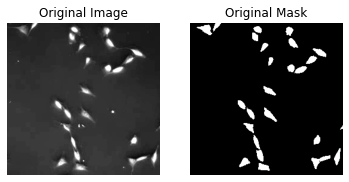

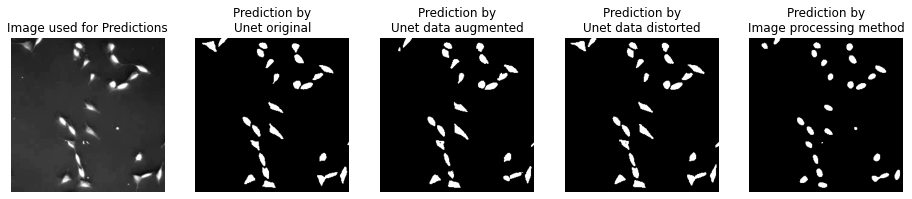

AMPLITUDE OF GAUSSIAN (BEFORE NORMALIZATION)      : 1000.0
UNET ORIGINAL
     Accuracy                                     : 0.954173428404565
     Jaccard score                                : 0.3527636070877456
     Precision                                    : 0.9216761125231856
     Recall                                       : 0.3646030560351639
     Number of cells in predictions               : 10580
     Number of cells in masks                     : 16183
UNET DATA AUGMENTED
     Accuracy                                     : 0.9475890215705423
     Jaccard score                                : 0.2527807783428968
     Precision                                    : 0.920417856497563
     Recall                                       : 0.259320808746812
     Number of cells in predictions               : 8591
     Number of cells in masks                     : 16183
UNET DATA DISTORTED
     Accuracy                                     : 0.9806446748621324
     Jaccard score  

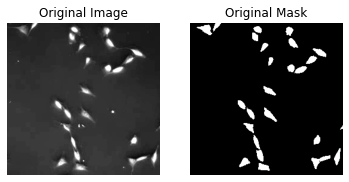

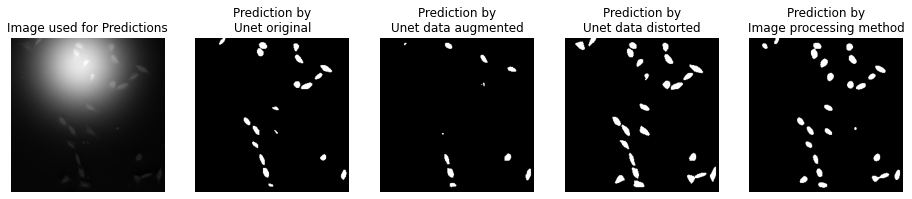

AMPLITUDE OF GAUSSIAN (BEFORE NORMALIZATION)      : 2000.0
UNET ORIGINAL
     Accuracy                                     : 0.9337350583543964
     Jaccard score                                : 0.022004376963583306
     Precision                                    : 0.810292897816969
     Recall                                       : 0.022079256901047044
     Number of cells in predictions               : 1919
     Number of cells in masks                     : 16183
UNET DATA AUGMENTED
     Accuracy                                     : 0.9325021182789522
     Jaccard score                                : 0.0053505375740621405
     Precision                                    : 0.4381885738253743
     Recall                                       : 0.005409142223294191
     Number of cells in predictions               : 1088
     Number of cells in masks                     : 16183
UNET DATA DISTORTED
     Accuracy                                     : 0.9496519500134037
     Jacca

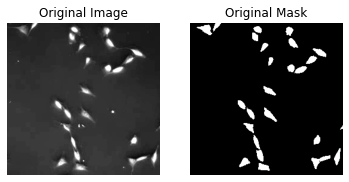

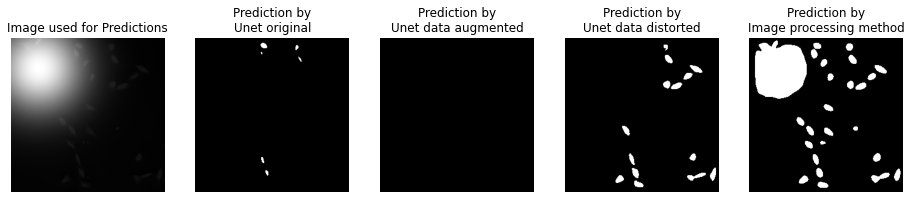

AMPLITUDE OF GAUSSIAN (BEFORE NORMALIZATION)      : 3000.0
UNET ORIGINAL
     Accuracy                                     : 0.9324860815908395
     Jaccard score                                : 0.0007373882774159763
     Precision                                    : 0.12172348748829528
     Recall                                       : 0.0007375081962845556
     Number of cells in predictions               : 593
     Number of cells in masks                     : 16183
UNET DATA AUGMENTED
     Accuracy                                     : 0.9321887745576747
     Jaccard score                                : 0.000686165419687566
     Precision                                    : 0.09657939712460079
     Recall                                       : 0.0006948686541333463
     Number of cells in predictions               : 674
     Number of cells in masks                     : 16183
UNET DATA DISTORTED
     Accuracy                                     : 0.9336496390548407
     Ja

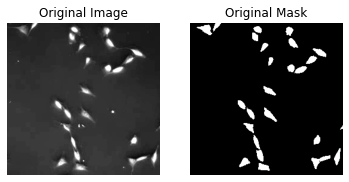

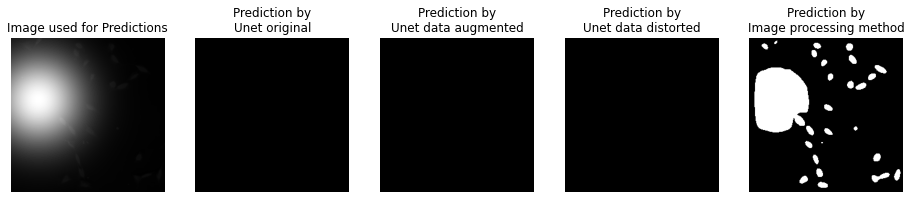

AMPLITUDE OF GAUSSIAN (BEFORE NORMALIZATION)      : 4000.0
UNET ORIGINAL
     Accuracy                                     : 0.932440185546875
     Jaccard score                                : 2.5122133093033693e-05
     Precision                                    : 0.01568627450980392
     Recall                                       : 2.5122133093033693e-05
     Number of cells in predictions               : 519
     Number of cells in masks                     : 16183
UNET DATA AUGMENTED
     Accuracy                                     : 0.9321523030598958
     Jaccard score                                : 0.0007227700417503091
     Precision                                    : 0.0421419120650775
     Recall                                       : 0.0007359359353179451
     Number of cells in predictions               : 666
     Number of cells in masks                     : 16183
UNET DATA DISTORTED
     Accuracy                                     : 0.9324534995883119
     J

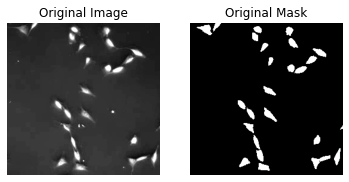

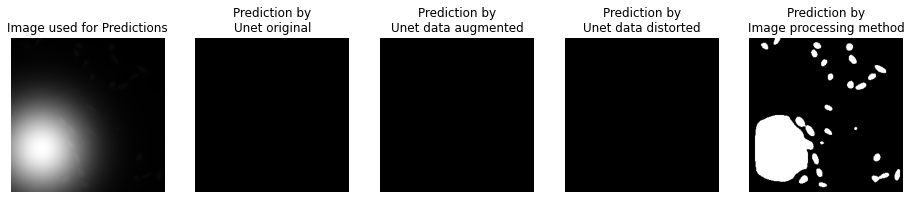

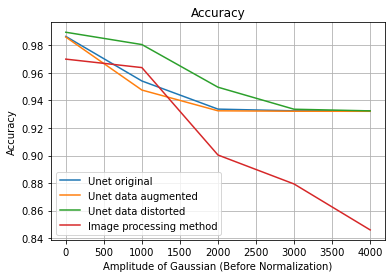

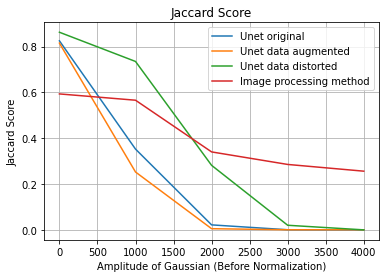

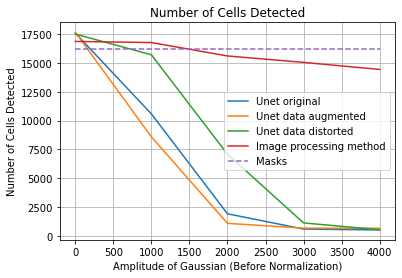

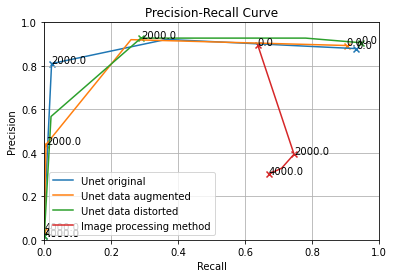

In [7]:
parameter_name = "Amplitude of Gaussian (Before Normalization)"

models_added_gaussian = models.copy()
models_added_gaussian["image processing method"] = DogImageProcessingMethod(ksize_low = 20)

amplitudes = np.linspace(0, 4000, 41)
results = {}

for amplitude in amplitudes:
    added_gaussian_test_images = apply_distortion_to_all(add_gaussian, test_images, {"amplitude": amplitude})
    
    result = evaluate_models(added_gaussian_test_images, test_masks, models_added_gaussian, number_cells_masks)
    results[amplitude] = result
    
    evaluation_summary(result, parameter_name, amplitude, test_images[0], test_masks[0], 
                       added_gaussian_test_images[0], models_added_gaussian)
    
plot_results(results, models_added_gaussian.keys(), parameter_name, [0, 2000, 4000])

### $\bullet$ Analysis of the perturbations caused by a gaussian noise on the UNET performance

STANDARD DEVIATION                                : 0.0
UNET ORIGINAL
     Accuracy                                     : 0.986560806573606
     Jaccard score                                : 0.8252888721210786
     Precision                                    : 0.8793119936478883
     Recall                                       : 0.9309741636841266
     Number of cells in predictions               : 17592
     Number of cells in masks                     : 16183
UNET DATA AUGMENTED
     Accuracy                                     : 0.9860904768401502
     Jaccard score                                : 0.8152214975792649
     Precision                                    : 0.8934886564411358
     Recall                                       : 0.9036087095416466
     Number of cells in predictions               : 17662
     Number of cells in masks                     : 16183
UNET DATA DISTORTED
     Accuracy                                     : 0.989585038727405
     Jaccard score   

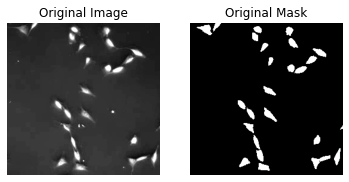

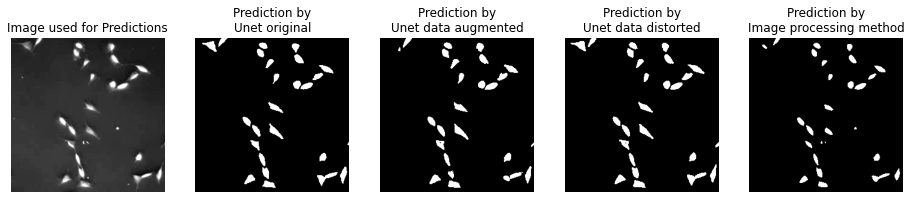

STANDARD DEVIATION                                : 50.0
UNET ORIGINAL
     Accuracy                                     : 0.8999142216701134
     Jaccard score                                : 0.3009462260339197
     Precision                                    : 0.3605758674356881
     Recall                                       : 0.6620978313851681
     Number of cells in predictions               : 110173
     Number of cells in masks                     : 16183
UNET DATA AUGMENTED
     Accuracy                                     : 0.9419526044060202
     Jaccard score                                : 0.3177343863615988
     Precision                                    : 0.5997566436959605
     Recall                                       : 0.40988795652011195
     Number of cells in predictions               : 68556
     Number of cells in masks                     : 16183
UNET DATA DISTORTED
     Accuracy                                     : 0.975449296539905
     Jaccard scor

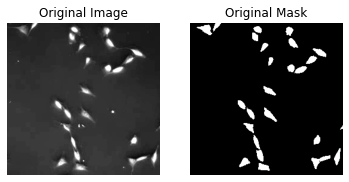

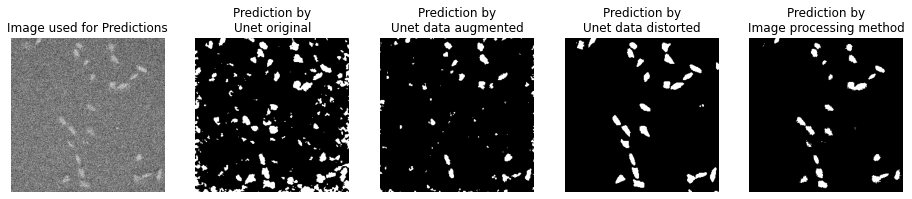

STANDARD DEVIATION                                : 100.0
UNET ORIGINAL
     Accuracy                                     : 0.868921137791054
     Jaccard score                                : 0.17194342768596774
     Precision                                    : 0.2317464388019955
     Recall                                       : 0.4178647699206728
     Number of cells in predictions               : 129322
     Number of cells in masks                     : 16183
UNET DATA AUGMENTED
     Accuracy                                     : 0.9200947780235141
     Jaccard score                                : 0.12069880409363631
     Precision                                    : 0.3179724814020101
     Recall                                       : 0.16804129183958816
     Number of cells in predictions               : 89520
     Number of cells in masks                     : 16183
UNET DATA DISTORTED
     Accuracy                                     : 0.9554519054936428
     Jaccard s

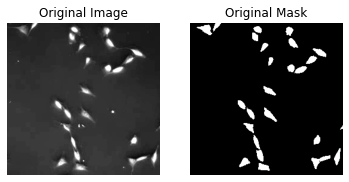

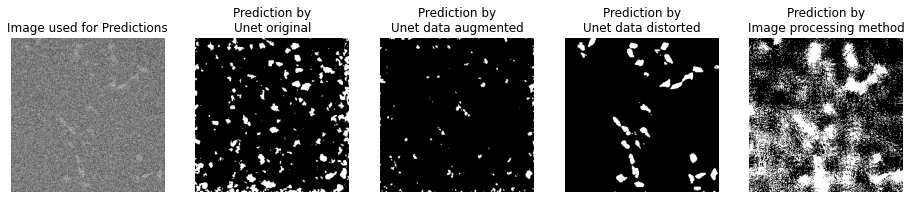

STANDARD DEVIATION                                : 150.0
UNET ORIGINAL
     Accuracy                                     : 0.8569148344152114
     Jaccard score                                : 0.11778873934082144
     Precision                                    : 0.16939214616449996
     Recall                                       : 0.29335221170611103
     Number of cells in predictions               : 135985
     Number of cells in masks                     : 16183
UNET DATA AUGMENTED
     Accuracy                                     : 0.9136673871208639
     Jaccard score                                : 0.06781103797060656
     Precision                                    : 0.20009316327960303
     Recall                                       : 0.0963600754549233
     Number of cells in predictions               : 93382
     Number of cells in masks                     : 16183
UNET DATA DISTORTED
     Accuracy                                     : 0.941571164598652
     Jaccard

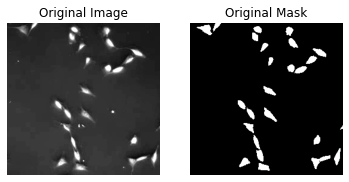

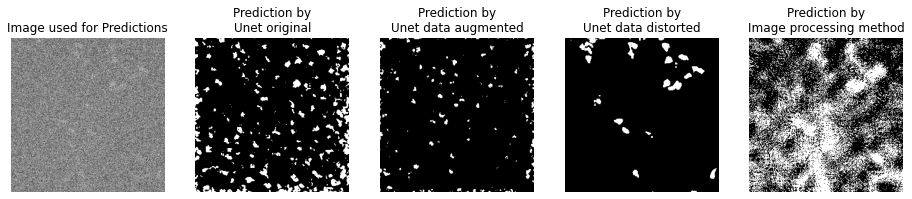

STANDARD DEVIATION                                : 200.0
UNET ORIGINAL
     Accuracy                                     : 0.8527789246802236
     Jaccard score                                : 0.09331058385152691
     Precision                                    : 0.13942248108238622
     Recall                                       : 0.23257645539120242
     Number of cells in predictions               : 137043
     Number of cells in masks                     : 16183
UNET DATA AUGMENTED
     Accuracy                                     : 0.9114389157762715
     Jaccard score                                : 0.047209464524080175
     Precision                                    : 0.14866654820676736
     Recall                                       : 0.06678614399324455
     Number of cells in predictions               : 93235
     Number of cells in masks                     : 16183
UNET DATA DISTORTED
     Accuracy                                     : 0.933731886919807
     Jacca

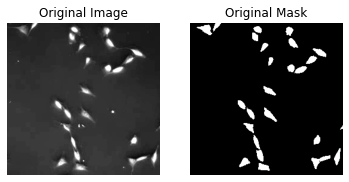

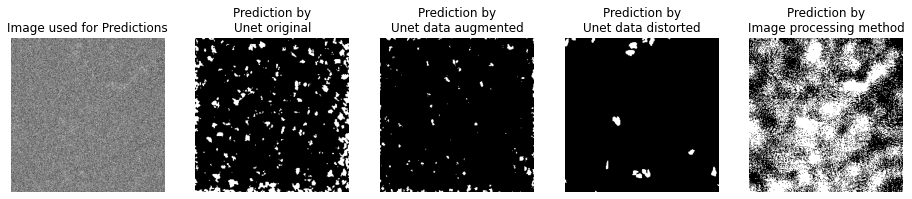

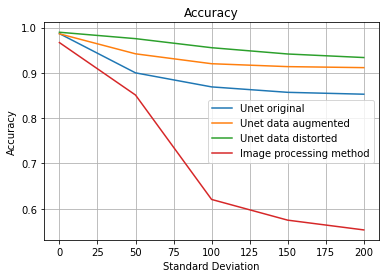

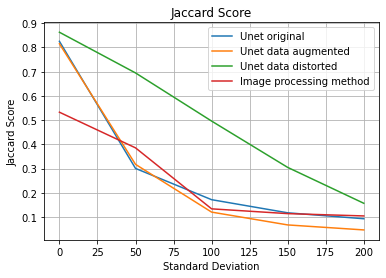

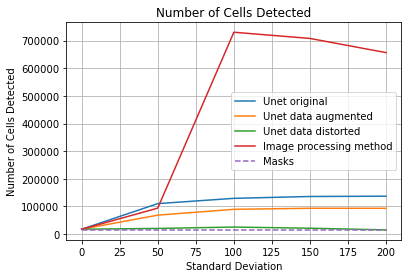

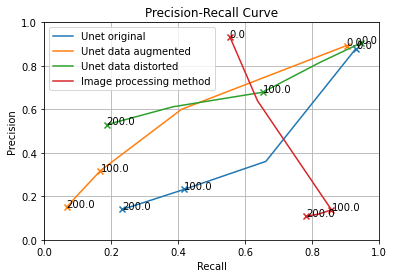

In [8]:
parameter_name = "Standard Deviation"

models_noisy = models.copy()
models_noisy["image processing method"] = DenoiserImageProcessingMethod(denoiser_strength = 25)

mean = 0
sigmas = np.linspace(0, 200, 41)
results = {}

for sigma in sigmas:
    noisy_test_images = apply_distortion_to_all(add_gaussian_noise, test_images, {"mean": mean, "sigma": sigma})

    result = evaluate_models(noisy_test_images, test_masks, models_noisy, number_cells_masks)
    results[sigma] = result
    
    evaluation_summary(result, parameter_name, sigma, test_images[0], test_masks[0], noisy_test_images[0], models_noisy)
        
plot_results(results, models_noisy.keys(), parameter_name, [0, 100, 200])

### $\bullet$ Analysis of the perturbations caused by a rescaling of the images on the UNET performance

ZOOMING FACTOR FROM PATCHES                       : 0.5
UNET ORIGINAL
     Accuracy                                     : 0.9857143028109682
     Jaccard score                                : 0.41395653774016267
     Precision                                    : 0.5449824441851083
     Recall                                       : 0.6332626540831271
     Number of cells in predictions               : 10173
     Number of cells in masks                     : 14702
UNET DATA AUGMENTED
     Accuracy                                     : 0.9825649485868566
     Jaccard score                                : 0.24851001659809177
     Precision                                    : 0.45863672871348704
     Recall                                       : 0.3637165516223408
     Number of cells in predictions               : 10607
     Number of cells in masks                     : 14702
UNET DATA DISTORTED
     Accuracy                                     : 0.9664896347943475
     Jaccard sco

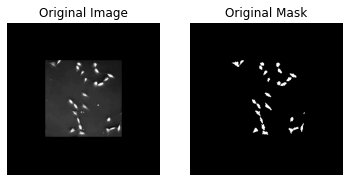

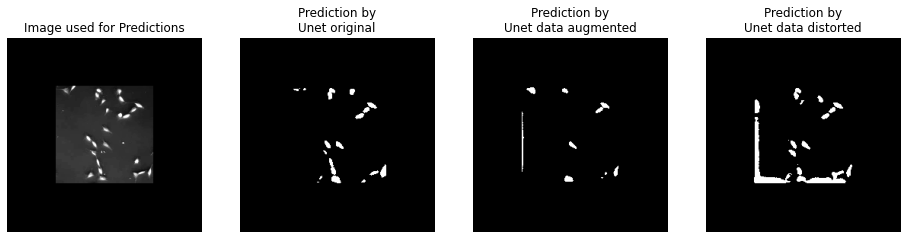

ZOOMING FACTOR FROM PATCHES                       : 1.0
UNET ORIGINAL
     Accuracy                                     : 0.9905527750651042
     Jaccard score                                : 0.8746940799580764
     Precision                                    : 0.9200386445999337
     Recall                                       : 0.9468060399405748
     Number of cells in predictions               : 16379
     Number of cells in masks                     : 16183
UNET DATA AUGMENTED
     Accuracy                                     : 0.9909422332165287
     Jaccard score                                : 0.8793279654508047
     Precision                                    : 0.9227204362154481
     Recall                                       : 0.9493503555493391
     Number of cells in predictions               : 16649
     Number of cells in masks                     : 16183
UNET DATA DISTORTED
     Accuracy                                     : 0.9897281123142616
     Jaccard score 

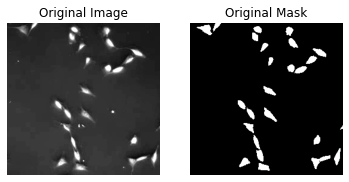

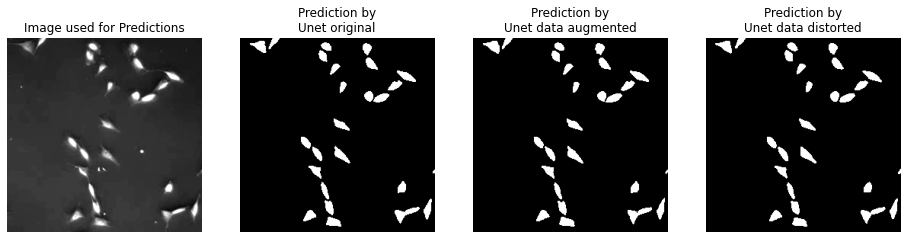

ZOOMING FACTOR FROM PATCHES                       : 1.5
UNET ORIGINAL
     Accuracy                                     : 0.9819555245193781
     Jaccard score                                : 0.7391145410920785
     Precision                                    : 0.9394351322720811
     Recall                                       : 0.7771627042778502
     Number of cells in predictions               : 9194
     Number of cells in masks                     : 8417
UNET DATA AUGMENTED
     Accuracy                                     : 0.9792721019071691
     Jaccard score                                : 0.6920139363090159
     Precision                                    : 0.9462669669033806
     Recall                                       : 0.7214167310435289
     Number of cells in predictions               : 9214
     Number of cells in masks                     : 8417
UNET DATA DISTORTED
     Accuracy                                     : 0.9810746735217525
     Jaccard score     

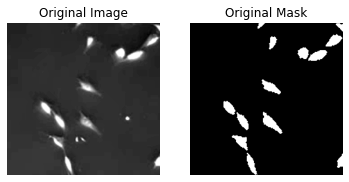

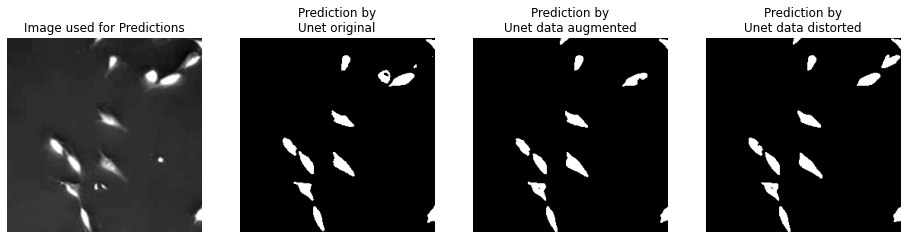

ZOOMING FACTOR FROM PATCHES                       : 2.0
UNET ORIGINAL
     Accuracy                                     : 0.9741808124617034
     Jaccard score                                : 0.6218735564979023
     Precision                                    : 0.9343846348536422
     Recall                                       : 0.6519869002110911
     Number of cells in predictions               : 6410
     Number of cells in masks                     : 4885
UNET DATA AUGMENTED
     Accuracy                                     : 0.9678652894263174
     Jaccard score                                : 0.5149062127180688
     Precision                                    : 0.9340538182744245
     Recall                                       : 0.535599372657397
     Number of cells in predictions               : 6816
     Number of cells in masks                     : 4885
UNET DATA DISTORTED
     Accuracy                                     : 0.972801866718367
     Jaccard score       

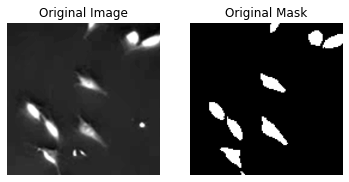

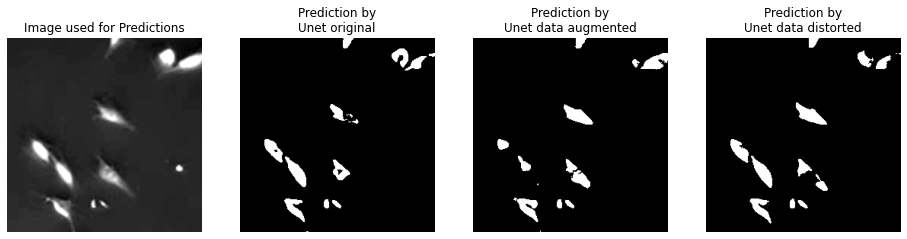

ZOOMING FACTOR FROM PATCHES                       : 3.5
UNET ORIGINAL
     Accuracy                                     : 0.9579072840073529
     Jaccard score                                : 0.3611129711558446
     Precision                                    : 0.8162195031236967
     Recall                                       : 0.3813292158026603
     Number of cells in predictions               : 3257
     Number of cells in masks                     : 2259
UNET DATA AUGMENTED
     Accuracy                                     : 0.9610838946174173
     Jaccard score                                : 0.4004457784182676
     Precision                                    : 0.835237461792491
     Recall                                       : 0.4199818031348545
     Number of cells in predictions               : 3326
     Number of cells in masks                     : 2259
UNET DATA DISTORTED
     Accuracy                                     : 0.9643862556008732
     Jaccard score      

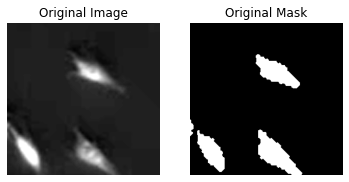

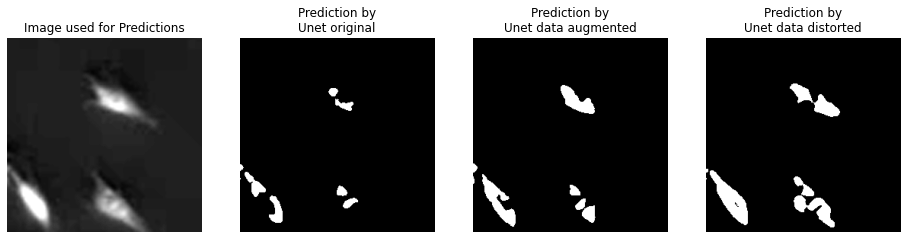

ZOOMING FACTOR FROM PATCHES                       : 5.0
UNET ORIGINAL
     Accuracy                                     : 0.9445324467677696
     Jaccard score                                : 0.14562268074539025
     Precision                                    : 0.6385147002820837
     Recall                                       : 0.1494947695512579
     Number of cells in predictions               : 1998
     Number of cells in masks                     : 1505
UNET DATA AUGMENTED
     Accuracy                                     : 0.9502003688438266
     Jaccard score                                : 0.21113276118549457
     Precision                                    : 0.6625273695423588
     Recall                                       : 0.2162312843248787
     Number of cells in predictions               : 2362
     Number of cells in masks                     : 1505
UNET DATA DISTORTED
     Accuracy                                     : 0.9532513786764706
     Jaccard score   

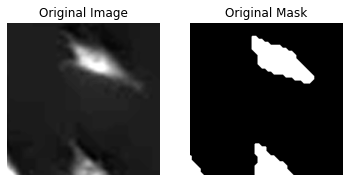

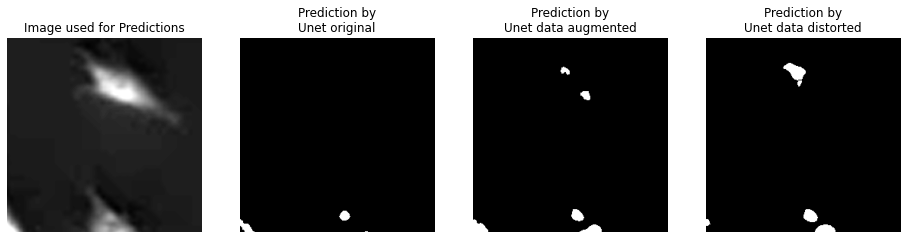

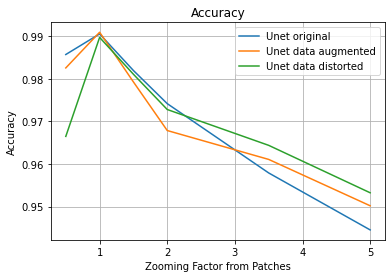

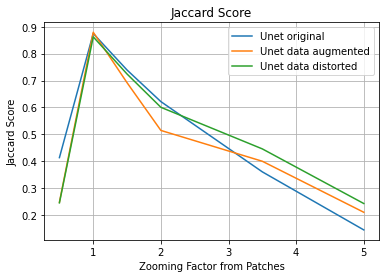

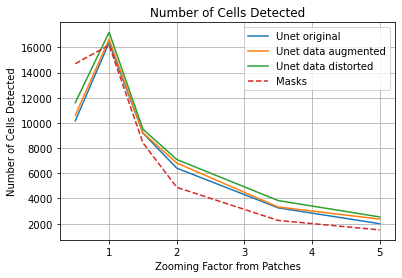

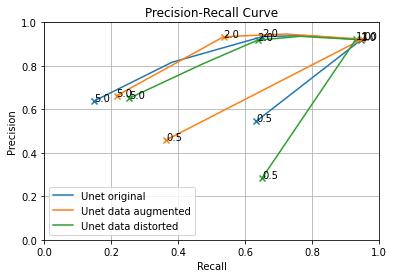

In [9]:
parameter_name = "Zooming Factor from Patches"

zooms = np.r_[np.linspace(0.5, 2, 15, endpoint=False), np.linspace(2, 5, 7)]
results = {}

for zoom in zooms:
    zoomed_test_images = apply_distortion_to_all(zoom_image, test_images, {"zoom_factor": zoom})
    zoomed_test_masks  = apply_distortion_to_all(zoom_image, test_masks , {"zoom_factor": zoom, "val_padding": 0})

    result = evaluate_models(zoomed_test_images, zoomed_test_masks, models)
    results[zoom] = result
    
    evaluation_summary(result, parameter_name, zoom, zoomed_test_images[0], zoomed_test_masks[0], zoomed_test_images[0], models)
    
plot_results(results, models.keys(), parameter_name, [0.5, 0.75, 1, 2, 5])

### $\bullet$ Get full input images from dataset

In [10]:
test_full_images, test_full_masks = get_dataset_from_folders(test_input_path, test_output_path)
full_images_shape = (*test_full_images[0].shape, 1)

print(f'Test set contains {len(test_full_images)} images of shape {full_images_shape}.')

Test set contains 85 images of shape (576, 720, 1).


### $\bullet$ Analysis of the perturbations caused by havind different sizes of cells on the UNET performance

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 0.5
UNET ORIGINAL
     Accuracy                                     : 0.9551215676700368
     Jaccard score                                : 0.4911321025859927
     Precision                                    : 0.6892956971121719
     Recall                                       : 0.6325245651193465
     Number of cells in predictions               : 38390
     Number of cells in masks                     : 56186
UNET DATA AUGMENTED
     Accuracy                                     : 0.9470159194048713
     Jaccard score                                : 0.32646462112002456
     Precision                                    : 0.7186272665659065
     Recall                                       : 0.37517309381013564
     Number of cells in predictions               : 34859
     Number of cells in masks                     : 56186
UNET DATA DISTORTED
     Accuracy                                     : 0.9548824534696692
     Jaccard scor

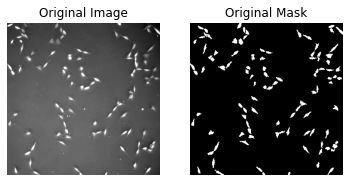

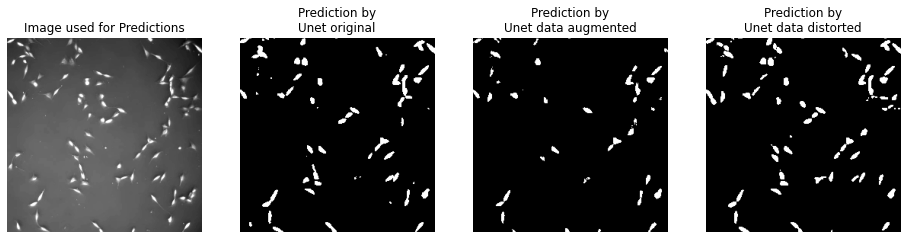

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 0.6
UNET ORIGINAL
     Accuracy                                     : 0.9710112029430913
     Jaccard score                                : 0.6732452081688547
     Precision                                    : 0.7733567321800552
     Recall                                       : 0.8391913080088503
     Number of cells in predictions               : 33521
     Number of cells in masks                     : 40763
UNET DATA AUGMENTED
     Accuracy                                     : 0.9658186968635111
     Jaccard score                                : 0.5911002328799767
     Precision                                    : 0.7945138115983275
     Recall                                       : 0.698447587382482
     Number of cells in predictions               : 33640
     Number of cells in masks                     : 40763
UNET DATA DISTORTED
     Accuracy                                     : 0.9716676300647212
     Jaccard score  

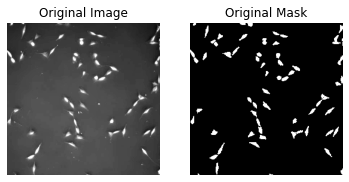

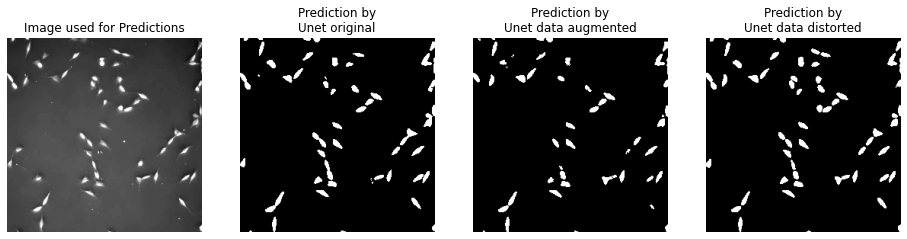

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 0.7
UNET ORIGINAL
     Accuracy                                     : 0.9799974329331342
     Jaccard score                                : 0.7654136198834411
     Precision                                    : 0.8183338171389462
     Recall                                       : 0.9221917327708347
     Number of cells in predictions               : 27908
     Number of cells in masks                     : 31139
UNET DATA AUGMENTED
     Accuracy                                     : 0.9791836906881893
     Jaccard score                                : 0.7515463252226173
     Precision                                    : 0.829493991264778
     Recall                                       : 0.8888512770974969
     Number of cells in predictions               : 28740
     Number of cells in masks                     : 31139
UNET DATA DISTORTED
     Accuracy                                     : 0.9804342531690411
     Jaccard score  

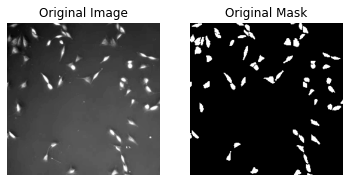

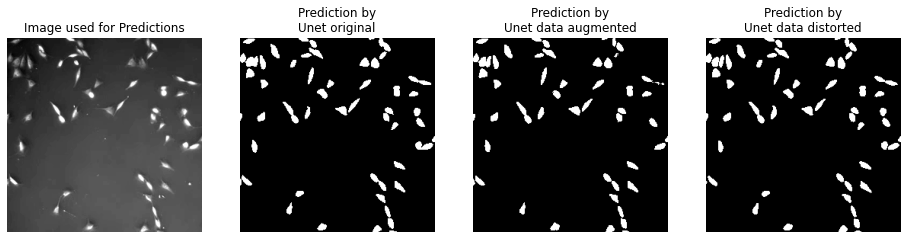

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 0.8
UNET ORIGINAL
     Accuracy                                     : 0.984880843817019
     Jaccard score                                : 0.8113837334071657
     Precision                                    : 0.8535313796729089
     Recall                                       : 0.9427749565752798
     Number of cells in predictions               : 22886
     Number of cells in masks                     : 23998
UNET DATA AUGMENTED
     Accuracy                                     : 0.9853524002374388
     Jaccard score                                : 0.8159873194260182
     Precision                                    : 0.8585732386621305
     Recall                                       : 0.94295664369642
     Number of cells in predictions               : 23415
     Number of cells in masks                     : 23998
UNET DATA DISTORTED
     Accuracy                                     : 0.9850845336914062
     Jaccard score    

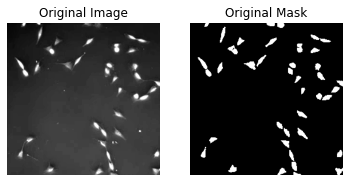

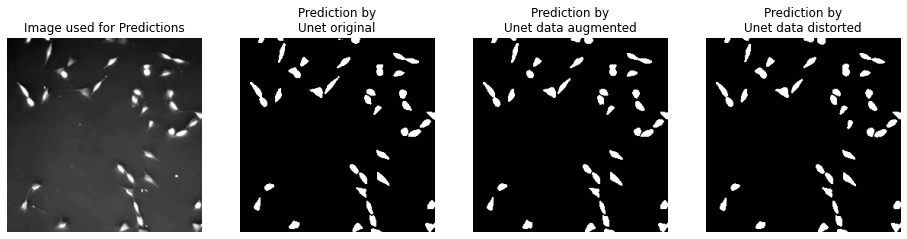

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 0.9
UNET ORIGINAL
     Accuracy                                     : 0.9866917030484068
     Jaccard score                                : 0.8321584049424577
     Precision                                    : 0.8786162920179846
     Recall                                       : 0.9404801221498656
     Number of cells in predictions               : 19529
     Number of cells in masks                     : 19781
UNET DATA AUGMENTED
     Accuracy                                     : 0.9872613046683517
     Jaccard score                                : 0.8389105933614563
     Precision                                    : 0.8814918057100065
     Recall                                       : 0.9458840712726406
     Number of cells in predictions               : 19856
     Number of cells in masks                     : 19781
UNET DATA DISTORTED
     Accuracy                                     : 0.9866590013691023
     Jaccard score 

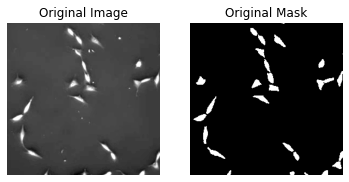

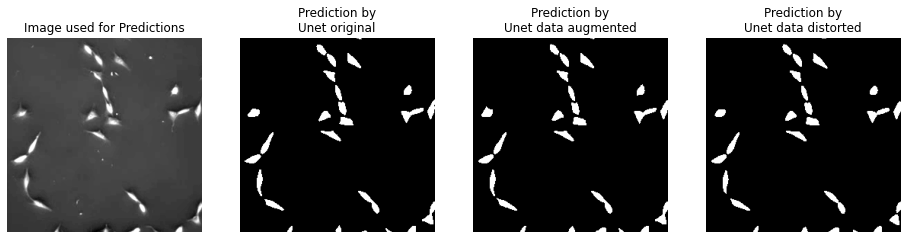

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 1.0
UNET ORIGINAL
     Accuracy                                     : 0.9904598460477941
     Jaccard score                                : 0.8737318911877272
     Precision                                    : 0.9192009105790147
     Recall                                       : 0.9465792372586813
     Number of cells in predictions               : 16423
     Number of cells in masks                     : 16151
UNET DATA AUGMENTED
     Accuracy                                     : 0.9909049838196997
     Jaccard score                                : 0.8794916784238825
     Precision                                    : 0.9214787078451804
     Recall                                       : 0.9508977834202004
     Number of cells in predictions               : 16651
     Number of cells in masks                     : 16151
UNET DATA DISTORTED
     Accuracy                                     : 0.9897362503350949
     Jaccard score 

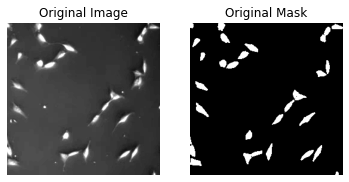

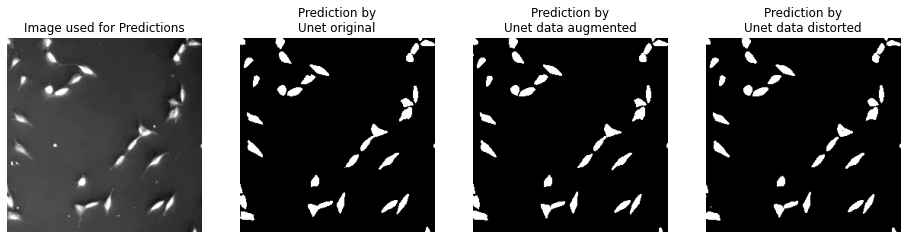

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 1.1
UNET ORIGINAL
     Accuracy                                     : 0.988045674812894
     Jaccard score                                : 0.8397002109506693
     Precision                                    : 0.9176408082428853
     Recall                                       : 0.9084066302364002
     Number of cells in predictions               : 16405
     Number of cells in masks                     : 15778
UNET DATA AUGMENTED
     Accuracy                                     : 0.9884252211626838
     Jaccard score                                : 0.8443081938302927
     Precision                                    : 0.9211579240602012
     Recall                                       : 0.9102286775986898
     Number of cells in predictions               : 16602
     Number of cells in masks                     : 15778
UNET DATA DISTORTED
     Accuracy                                     : 0.9874430680475315
     Jaccard score  

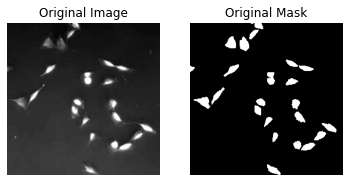

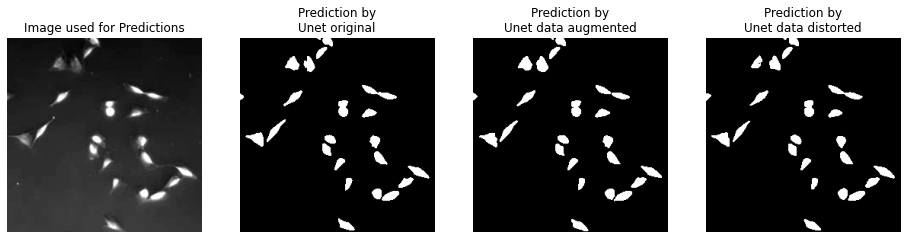

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 1.2000000000000002
UNET ORIGINAL
     Accuracy                                     : 0.9866189395680147
     Jaccard score                                : 0.8213895243664202
     Precision                                    : 0.9237919010178238
     Recall                                       : 0.8815578175044998
     Number of cells in predictions               : 18940
     Number of cells in masks                     : 17691
UNET DATA AUGMENTED
     Accuracy                                     : 0.9869810216567095
     Jaccard score                                : 0.8248379958760943
     Precision                                    : 0.9288519882122529
     Recall                                       : 0.8808637415050087
     Number of cells in predictions               : 19140
     Number of cells in masks                     : 17691
UNET DATA DISTORTED
     Accuracy                                     : 0.985964905981924
     

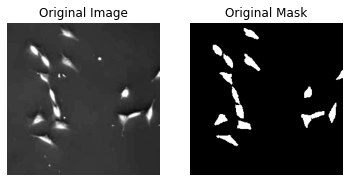

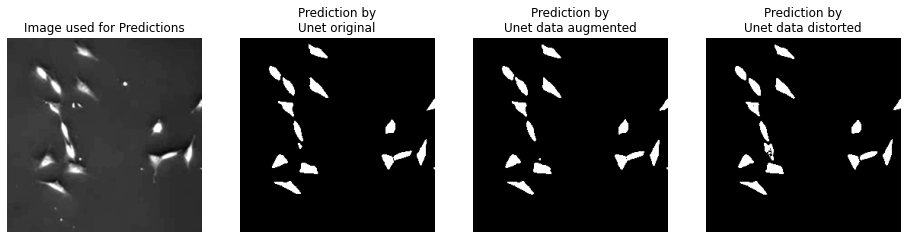

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 1.3
UNET ORIGINAL
     Accuracy                                     : 0.9842138133329503
     Jaccard score                                : 0.7908939066835078
     Precision                                    : 0.924822691584252
     Recall                                       : 0.8459526522051583
     Number of cells in predictions               : 19222
     Number of cells in masks                     : 17348
UNET DATA AUGMENTED
     Accuracy                                     : 0.9842604513729319
     Jaccard score                                : 0.7879078058470047
     Precision                                    : 0.932504314395372
     Recall                                       : 0.8364168938789932
     Number of cells in predictions               : 19258
     Number of cells in masks                     : 17348
UNET DATA DISTORTED
     Accuracy                                     : 0.9834846586339614
     Jaccard score   

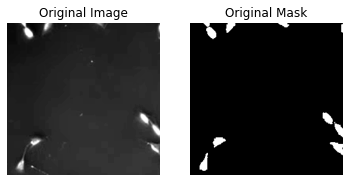

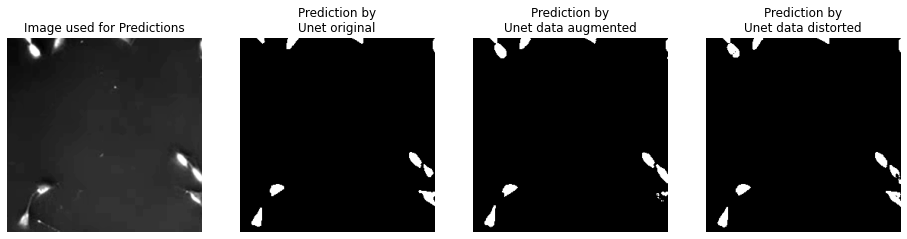

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 1.4
UNET ORIGINAL
     Accuracy                                     : 0.9826118768430223
     Jaccard score                                : 0.7598848320017195
     Precision                                    : 0.9293993000563777
     Recall                                       : 0.8073232934870662
     Number of cells in predictions               : 20493
     Number of cells in masks                     : 17795
UNET DATA AUGMENTED
     Accuracy                                     : 0.981419656790939
     Jaccard score                                : 0.7369114761137847
     Precision                                    : 0.9361508890338912
     Recall                                       : 0.7766581069255765
     Number of cells in predictions               : 20543
     Number of cells in masks                     : 17795
UNET DATA DISTORTED
     Accuracy                                     : 0.9817935719209558
     Jaccard score  

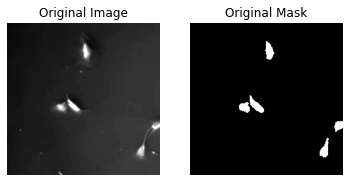

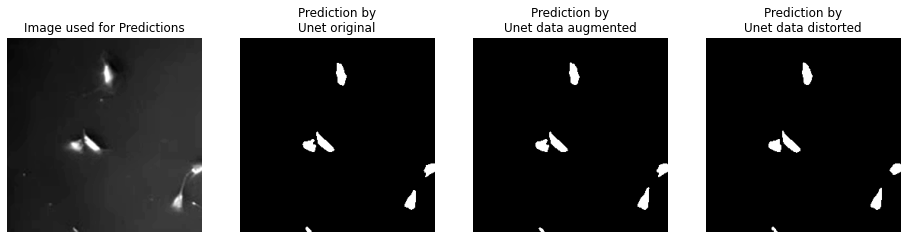

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 1.5
UNET ORIGINAL
     Accuracy                                     : 0.980071880436745
     Jaccard score                                : 0.7274438983992807
     Precision                                    : 0.9300287311939126
     Recall                                       : 0.771239431786058
     Number of cells in predictions               : 22444
     Number of cells in masks                     : 18928
UNET DATA AUGMENTED
     Accuracy                                     : 0.9776190493287159
     Jaccard score                                : 0.684461977454569
     Precision                                    : 0.9365890583471982
     Recall                                       : 0.7196257336398467
     Number of cells in predictions               : 22481
     Number of cells in masks                     : 18928
UNET DATA DISTORTED
     Accuracy                                     : 0.9792328009084493
     Jaccard score    

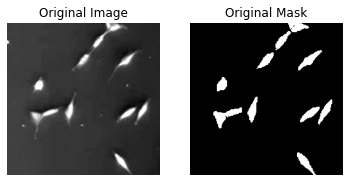

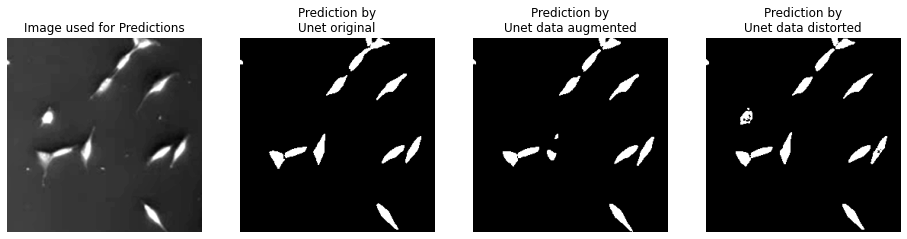

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 1.6
UNET ORIGINAL
     Accuracy                                     : 0.9780841939589556
     Jaccard score                                : 0.7030836495452821
     Precision                                    : 0.9287583895384036
     Recall                                       : 0.7447892583098514
     Number of cells in predictions               : 23865
     Number of cells in masks                     : 19759
UNET DATA AUGMENTED
     Accuracy                                     : 0.9744462742524989
     Jaccard score                                : 0.6372957986660095
     Precision                                    : 0.9348062589854531
     Recall                                       : 0.6691681288680739
     Number of cells in predictions               : 24115
     Number of cells in masks                     : 19759
UNET DATA DISTORTED
     Accuracy                                     : 0.9769688213572782
     Jaccard score 

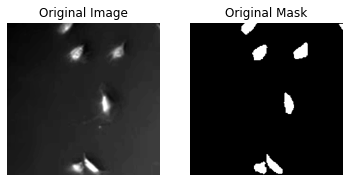

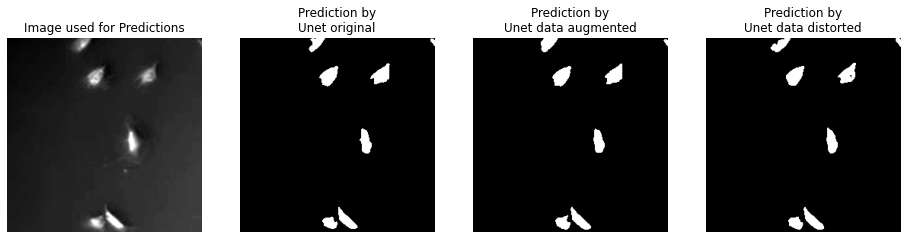

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 1.7000000000000002
UNET ORIGINAL
     Accuracy                                     : 0.9752961002923305
     Jaccard score                                : 0.6757286298701285
     Precision                                    : 0.9276319205112284
     Recall                                       : 0.7144151415184476
     Number of cells in predictions               : 25984
     Number of cells in masks                     : 20777
UNET DATA AUGMENTED
     Accuracy                                     : 0.970668907414854
     Jaccard score                                : 0.5988915829850793
     Precision                                    : 0.9323544136732395
     Recall                                       : 0.6278259197048136
     Number of cells in predictions               : 26273
     Number of cells in masks                     : 20777
UNET DATA DISTORTED
     Accuracy                                     : 0.9737560297149459
     

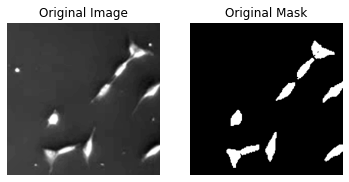

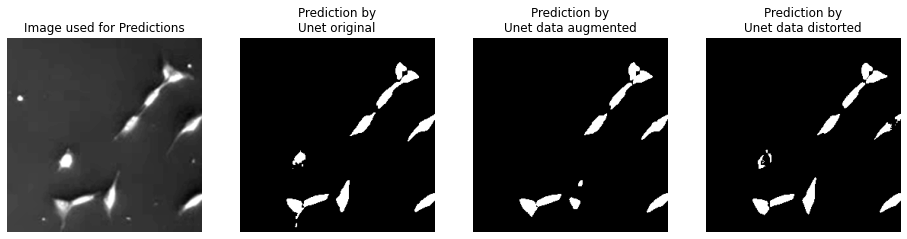

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 1.8
UNET ORIGINAL
     Accuracy                                     : 0.9738883254107307
     Jaccard score                                : 0.6544378881637707
     Precision                                    : 0.9258765463714005
     Recall                                       : 0.6922670226650786
     Number of cells in predictions               : 26780
     Number of cells in masks                     : 21036
UNET DATA AUGMENTED
     Accuracy                                     : 0.9686145737591911
     Jaccard score                                : 0.566605861705607
     Precision                                    : 0.9300808699382963
     Recall                                       : 0.594145416047983
     Number of cells in predictions               : 27242
     Number of cells in masks                     : 21036
UNET DATA DISTORTED
     Accuracy                                     : 0.9722409865435432
     Jaccard score   

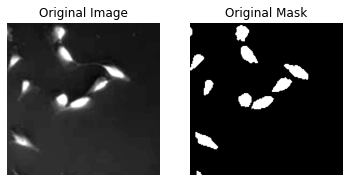

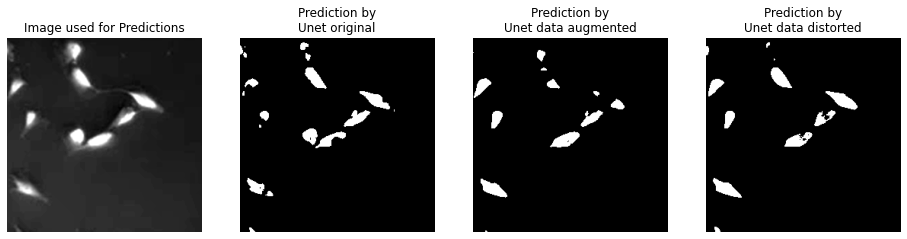

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 1.9000000000000001
UNET ORIGINAL
     Accuracy                                     : 0.9728279757682625
     Jaccard score                                : 0.6325250969968632
     Precision                                    : 0.9198308285355962
     Recall                                       : 0.6713128467580285
     Number of cells in predictions               : 28244
     Number of cells in masks                     : 21517
UNET DATA AUGMENTED
     Accuracy                                     : 0.9670513884795596
     Jaccard score                                : 0.5375792374645227
     Precision                                    : 0.9220606911862089
     Recall                                       : 0.5652487342185754
     Number of cells in predictions               : 29058
     Number of cells in masks                     : 21517
UNET DATA DISTORTED
     Accuracy                                     : 0.9711027101482577
    

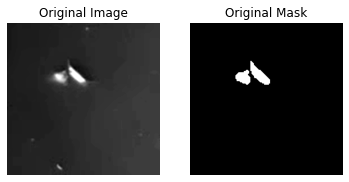

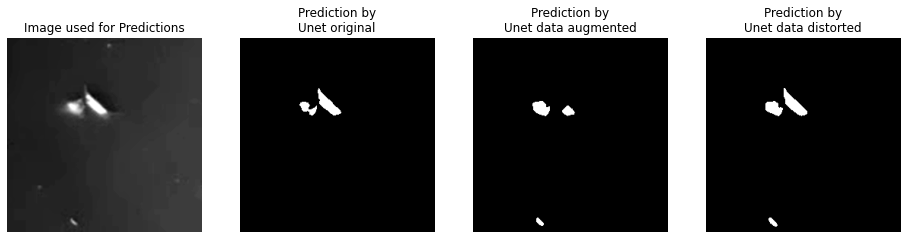

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 2.0
UNET ORIGINAL
     Accuracy                                     : 0.971584285960478
     Jaccard score                                : 0.6179864390077804
     Precision                                    : 0.9202280247448615
     Recall                                       : 0.6541799925241589
     Number of cells in predictions               : 29296
     Number of cells in masks                     : 21617
UNET DATA AUGMENTED
     Accuracy                                     : 0.9655715547449448
     Jaccard score                                : 0.5216716589543152
     Precision                                    : 0.9204833536529807
     Recall                                       : 0.5467795384470834
     Number of cells in predictions               : 30348
     Number of cells in masks                     : 21617
UNET DATA DISTORTED
     Accuracy                                     : 0.969837308995864
     Jaccard score   

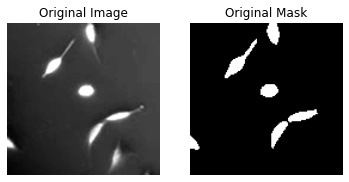

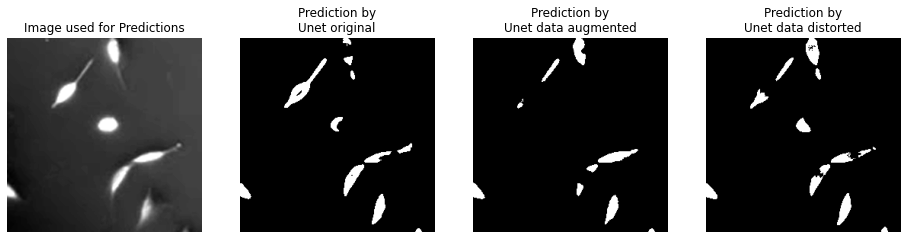

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 2.5
UNET ORIGINAL
     Accuracy                                     : 0.9646267345767935
     Jaccard score                                : 0.5280105349326111
     Precision                                    : 0.8845076516135404
     Recall                                       : 0.5664018875737995
     Number of cells in predictions               : 34646
     Number of cells in masks                     : 24618
UNET DATA AUGMENTED
     Accuracy                                     : 0.9614785080761571
     Jaccard score                                : 0.4794889896242051
     Precision                                    : 0.8933848217712036
     Recall                                       : 0.5077198188283116
     Number of cells in predictions               : 36030
     Number of cells in masks                     : 24618
UNET DATA DISTORTED
     Accuracy                                     : 0.9657800826911294
     Jaccard score 

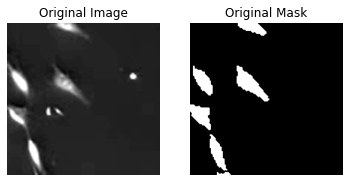

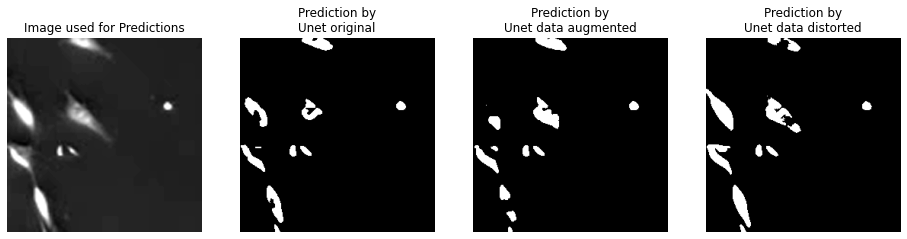

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 3.0
UNET ORIGINAL
     Accuracy                                     : 0.957986843868921
     Jaccard score                                : 0.4377230787207403
     Precision                                    : 0.8422270937486965
     Recall                                       : 0.46861456495482423
     Number of cells in predictions               : 40805
     Number of cells in masks                     : 28281
UNET DATA AUGMENTED
     Accuracy                                     : 0.9574639539846572
     Jaccard score                                : 0.42805118683357574
     Precision                                    : 0.8566207854881035
     Recall                                       : 0.4529922549632463
     Number of cells in predictions               : 41525
     Number of cells in masks                     : 28281
UNET DATA DISTORTED
     Accuracy                                     : 0.9619329241899268
     Jaccard score

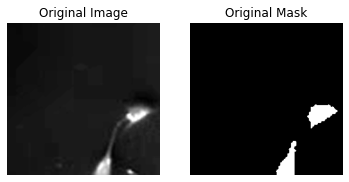

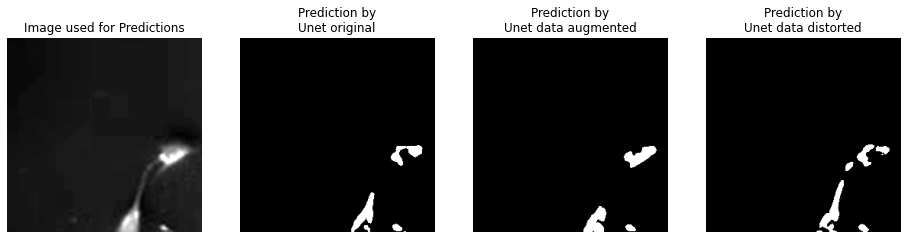

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 3.5
UNET ORIGINAL
     Accuracy                                     : 0.9529174734746526
     Jaccard score                                : 0.34356040225350254
     Precision                                    : 0.7827226752492076
     Recall                                       : 0.3658044628373239
     Number of cells in predictions               : 44044
     Number of cells in masks                     : 30892
UNET DATA AUGMENTED
     Accuracy                                     : 0.954657080339238
     Jaccard score                                : 0.3646846192497926
     Precision                                    : 0.8017255870065682
     Recall                                       : 0.3841831026372494
     Number of cells in predictions               : 44583
     Number of cells in masks                     : 30892
UNET DATA DISTORTED
     Accuracy                                     : 0.9590603775245894
     Jaccard score 

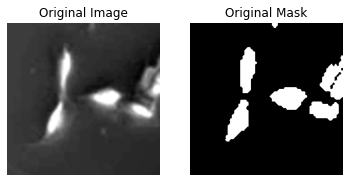

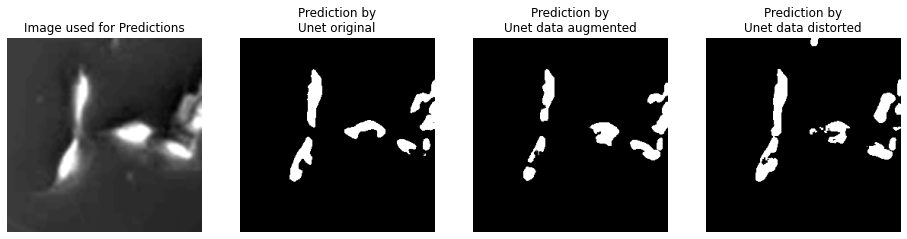

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 4.0
UNET ORIGINAL
     Accuracy                                     : 0.9485252133537742
     Jaccard score                                : 0.2653580812612514
     Precision                                    : 0.7357657548282436
     Recall                                       : 0.28033742931201744
     Number of cells in predictions               : 37906
     Number of cells in masks                     : 26817
UNET DATA AUGMENTED
     Accuracy                                     : 0.9518326007618624
     Jaccard score                                : 0.3075892690751243
     Precision                                    : 0.7562259767370172
     Recall                                       : 0.3227744758796966
     Number of cells in predictions               : 38745
     Number of cells in masks                     : 26817
UNET DATA DISTORTED
     Accuracy                                     : 0.9556551922068877
     Jaccard score

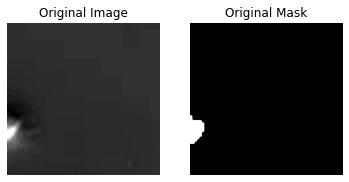

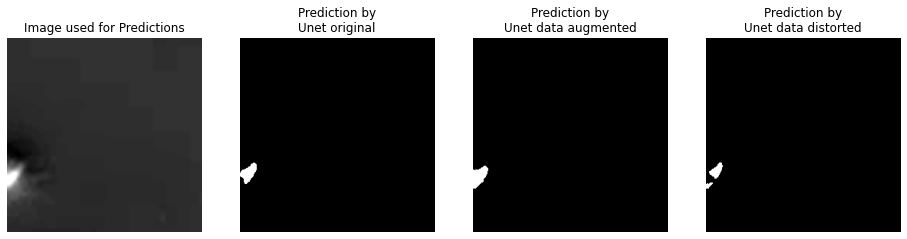

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 4.5
UNET ORIGINAL
     Accuracy                                     : 0.9432687983793371
     Jaccard score                                : 0.18329252420533468
     Precision                                    : 0.659490617868707
     Recall                                       : 0.19199481028436932
     Number of cells in predictions               : 30755
     Number of cells in masks                     : 23094
UNET DATA AUGMENTED
     Accuracy                                     : 0.9477537155151368
     Jaccard score                                : 0.2372030865547132
     Precision                                    : 0.6825150519632402
     Recall                                       : 0.2479963859613392
     Number of cells in predictions               : 32757
     Number of cells in masks                     : 23094
UNET DATA DISTORTED
     Accuracy                                     : 0.9511267875222599
     Jaccard score

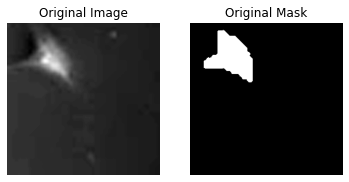

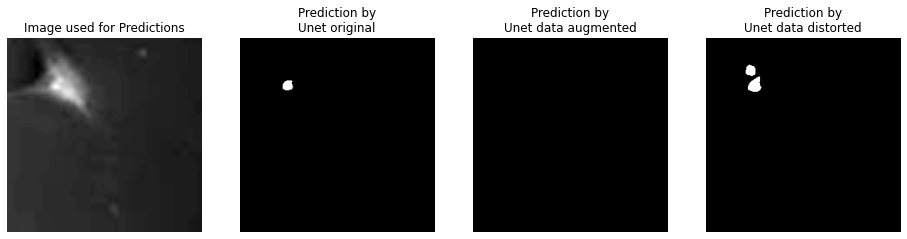

ZOOMING FACTOR FROM ORIGINAL IMAGES               : 5.0
UNET ORIGINAL
     Accuracy                                     : 0.9390461125093348
     Jaccard score                                : 0.13884985437537328
     Precision                                    : 0.6150118757776859
     Recall                                       : 0.14414664899760032
     Number of cells in predictions               : 27059
     Number of cells in masks                     : 21029
UNET DATA AUGMENTED
     Accuracy                                     : 0.9439138816384708
     Jaccard score                                : 0.19382253924805648
     Precision                                    : 0.6432801480694946
     Recall                                       : 0.20165632616291665
     Number of cells in predictions               : 30494
     Number of cells in masks                     : 21029
UNET DATA DISTORTED
     Accuracy                                     : 0.9470524776683135
     Jaccard sc

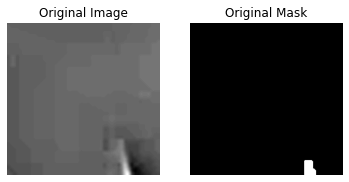

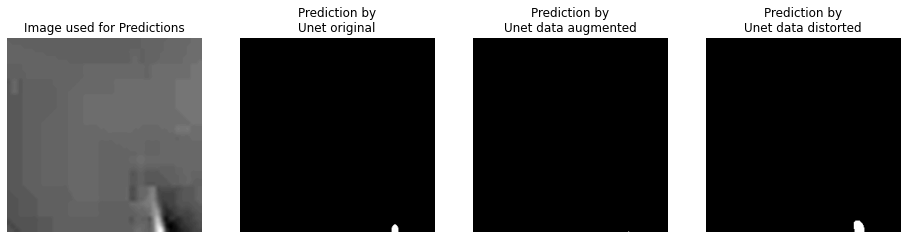

KeyError: 'Z'

In [11]:
parameter_name = "Zooming Factor from Original Images"

zooms = np.r_[np.linspace(0.5, 2, 15, endpoint=False), np.linspace(2, 5, 7)]
results = {}

for zoom in zooms:
    patch_shape = (int(images_shape[0] / zoom), int(images_shape[1] / zoom), 1)
    n_patches = np.clip(np.prod(np.divide(full_images_shape, patch_shape)), 6, 80).astype('uint')
    patch_images, patch_masks = split_images_and_masks_into_patches(test_full_images, test_full_masks, patch_shape, n_patches)
    
    zoomed_test_images = apply_distortion_to_all(zoom_image_to_meet_shape, patch_images, {"shape": images_shape})
    zoomed_test_masks  = apply_distortion_to_all(zoom_image_to_meet_shape, patch_masks , {"shape": images_shape})

    result = evaluate_models(zoomed_test_images, zoomed_test_masks, models)
    results[zoom] = result
    
    evaluation_summary(result, parameter_name, zoom, zoomed_test_images[0], zoomed_test_masks[0], zoomed_test_images[0], models)
    
plot_results(results, models.keys(), parameter_name, [0.5, 0.75, 1, 2, 5])